In [56]:
print("Test notebook connection")

Test notebook connection


In [57]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pytorch_lightning as pl
from torchvision import transforms, datasets
import torch
import wandb
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

In [58]:
wandb.login()

True

# **1. Data acquisition**

The images are mostly from Pinterest or other image sharing platforms.


They were downloaded and uploaded to this repository manually, from where this code can access it

# **2. Data analysis**

In [59]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [60]:
bagel_images = load_images_from_folder('images/train/bagel')
burger_images = load_images_from_folder('images/train/burger')
sandwich_images = load_images_from_folder('images/train/sandwich')

In [61]:
len(bagel_images), len(burger_images), len(sandwich_images)

(50, 50, 50)

### Class distribution
We have 50 images of three classes.

The classes are:
- Bagel
- Burger
- Sandwich

The class distribution is equal since we have 50 images in all classes, so there are no class imbalances.



In [62]:
dataset_path = 'images/train'

### Visualizing samples

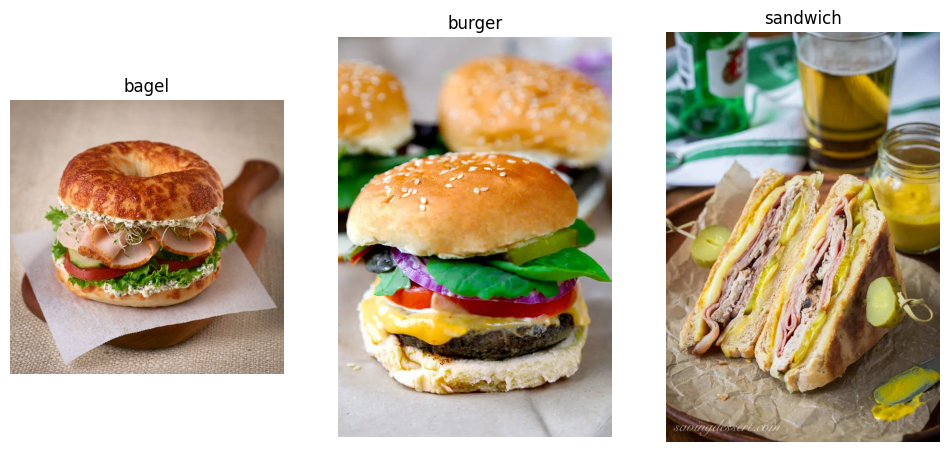

In [63]:
def analyze_dataset(dataset_path):
    class_samples = {}
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        
        if os.path.isdir(class_path):
            image_files = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]
            class_samples[class_name] = [os.path.join(class_path, img) for img in image_files[:5]]

    plt.figure(figsize=(12, 6))
    for idx, (class_name, samples) in enumerate(class_samples.items()):
        plt.subplot(1, len(class_samples), idx + 1)
        for img_path in samples:
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)
    plt.show()

analyze_dataset(dataset_path)

### Check image corruption

In [64]:
def check_image_corruption(dataset_path):
    corrupted_images = []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)

        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                if os.path.isfile(img_path):
                    try:
                        img = Image.open(img_path)
                        img.verify()
                    except Exception as e:
                        corrupted_images.append(img_path)
                        print(f"Corrupted image: {img_path}")

    if corrupted_images:
        print(f"Total corrupted images: {len(corrupted_images)}")
    else:
        print("No corrupted images found.")

check_image_corruption('images/train')
check_image_corruption('images/test')
check_image_corruption('images/val')

No corrupted images found.
No corrupted images found.
No corrupted images found.


### Statistical analysis

In [65]:
def calculate_image_statistics(dataset_path):
    widths, heights = [], []
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                if os.path.isfile(img_path):
                    img = Image.open(img_path)
                    widths.append(img.width)
                    heights.append(img.height)
    
    if widths and heights:
        print(f"Average width: {np.mean(widths)}, Average height: {np.mean(heights)}")
    else:
        print("No valid images found.")

calculate_image_statistics('images/train')
calculate_image_statistics('images/val')


Average width: 582.9066666666666, Average height: 703.9866666666667
Average width: 1152.0, Average height: 896.0


# **3. Data cleansing and preparation**

In [85]:
class BurgerBagelSandwichDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, resolution=224, num_workers=4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.resolution = resolution
        self.num_workers = num_workers

        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=self.resolution, scale=(0.25, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.val_transform = transforms.Compose([
            transforms.Resize(size=self.resolution, antialias=True),
            transforms.CenterCrop(size=self.resolution),
            transforms.ToTensor(),
        ])

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = datasets.ImageFolder(
                root=f'{self.data_dir}/train',
                transform=self.train_transform
            )

            self.val_dataset = datasets.ImageFolder(
                root=f'{self.data_dir}/val',
                transform=self.val_transform
            )

        if stage == 'test' or stage is None:
            self.test_dataset = datasets.ImageFolder(
                root=f'{self.data_dir}/test',
                transform=self.val_transform
            )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            shuffle=True,
            drop_last=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
        )

In [86]:
data_module = BurgerBagelSandwichDataModule(data_dir='images', batch_size=16, resolution=224, num_workers=1)
data_module.setup('fit')

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

In [87]:
train_loader.dataset.classes, val_loader.dataset.classes

(['bagel', 'burger', 'sandwich'], ['bagel', 'burger', 'sandwich'])

# Phase 2

## Defining evaluation criteria 

- Accuracy: Ration of correctly predicted instances to the total instances
- Precision: Ratio of true positive predictions to the sum of true positives and false positives for each class
- Recall: Ratio of true positive predictions to the sum of true positives and false negatives for each class
- F1 Score: The harmonic mean of precision and recall. It provides a balance between the two metrics
- Confusion Matrix: A matrix that shows the number of correct and incorrect predictions broken down by class

## Baseline Model

### Define hyperparams

In [88]:
learning_rate = 1e-3
max_epochs = 50
dropout_rate = 0.5
weight_decay = 1e-5

### Define baseline model

In [89]:
class BaselineModel(pl.LightningModule):
    def __init__(self, num_classes=3):
        super(BaselineModel, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 112 * 112, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.weight_decay = weight_decay
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [ ]:
baseline_model = BaselineModel(num_classes=3)
trainer = pl.Trainer(max_epochs=max_epochs)
trainer.fit(baseline_model, data_module)
trainer.test(baseline_model, data_module)

## Incremental model development

### Add complexity

In [91]:
class ComplexModel(pl.LightningModule):
    def __init__(self, num_classes=3):
        super(ComplexModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)

In [92]:
complex_model = ComplexModel(num_classes=3)
trainer = pl.Trainer(max_epochs=max_epochs)
trainer.fit(complex_model, data_module)
trainer.test(complex_model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | conv_layers | Sequential       | 19.4 K | train
1 | fc_layers   | Sequential       | 25.7 M | train
2 | criterion   | CrossEntropyLoss | 0      | train
---------------------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.840   Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0997382402420044
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0997382402420044}]

### Use transfer learning

In [93]:
class TransferLearningModel(pl.LightningModule):
    def __init__(self, num_classes=3):
        super(TransferLearningModel, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("val_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)
        self.log("test_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [ ]:
transfer_model = TransferLearningModel()
trainer = pl.Trainer(max_epochs=max_epochs)
trainer.fit(transfer_model, data_module)
trainer.test(transfer_model, data_module)

### Ensemble models

In [50]:
class EnsembleModel(pl.LightningModule):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = models
        self.criterion = nn.CrossEntropyLoss()

        for model in self.models:
            if len(list(model.parameters())) == 0:
                print(f"Model {model.__class__.__name__} has no parameters.")

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.mean(torch.stack(outputs), dim=0)

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.criterion(outputs, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.criterion(outputs, y)
        acc = (torch.argmax(outputs, dim=1) == y).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        acc = (torch.argmax(outputs, dim=1) == y).float().mean()
        self.log('test_acc', acc)

    def configure_optimizers(self):
        params = [p for model in self.models for p in model.parameters()]
        if not params:
            raise ValueError("No parameters found for optimization.")
        
        optimizer = torch.optim.Adam(params, lr=0.001)
        return optimizer
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            outputs = self(x)
            predictions = torch.argmax(outputs, dim=1)
        return predictions

In [51]:
ensemble = EnsembleModel(models=[baseline_model, complex_model, transfer_model])

### Set up wandb and logging

In [52]:
wandb_logger = pl.loggers.WandbLogger(project='food-classification-homework', log_model="all")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1)
trainer = pl.Trainer(
    max_epochs=max_epochs,
    logger=wandb_logger,
    callbacks=[checkpoint_callback]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(ensemble, data_module)
wandb.finish()

In [54]:
## Run this if you interrupted the run
# wandb.finish()

epoch,▁█
trainer/global_step,▁█
val_acc,█▁
val_loss,▁█
epoch,1
trainer/global_step,7
val_acc,0.37778
val_loss,2.83308


### Load up the best model from the run

In [96]:
best_model_path = checkpoint_callback.best_model_path
myModel = EnsembleModel(models=[baseline_model, complex_model, transfer_model])

best_model = EnsembleModel.load_from_checkpoint(best_model_path, models=[baseline_model, complex_model, transfer_model])

/usr/local/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:94: The state dict in './food-classification-homework/weayj9ww/checkpoints/epoch=8-step=36.ckpt' contains no parameters.


### Define some helper functions

In [101]:
def preprocess_image(image_path, resolution=224):
    preprocess = transforms.Compose([
        transforms.Resize(resolution),
        transforms.CenterCrop(resolution),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img = Image.open(image_path).convert("RGB")
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)

    return img_tensor

def predict_image(model, image_path):
    model.eval()

    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    img_tensor = preprocess_image(image_path)
    
    with torch.no_grad():
        output = model(img_tensor)
    
    predicted_class_index = torch.argmax(output, dim=1).item()
    class_names = data_module.train_dataset.classes
    predicted_class_name = class_names[predicted_class_index]

    print(f'The predicted class for the image is: {predicted_class_name}')

### Make a prediction on a test bagel image

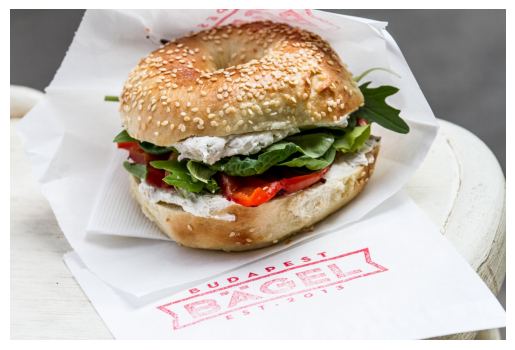

The predicted class for the image is: bagel


In [103]:
image_path = './images/test/bagel/test_2.jpg'
predict_image(best_model, image_path)


### Make a prediction on a test burger image

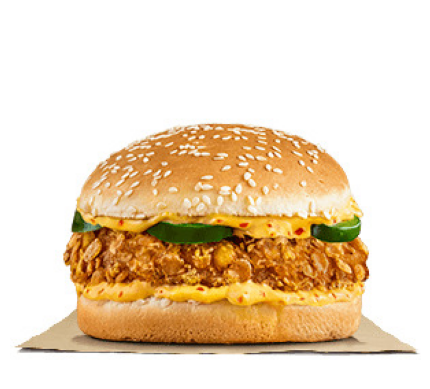

The predicted class for the image is: sandwich


In [108]:
image_path_2 = './images/test/burger/test_5.jpg'
predict_image(best_model, image_path_2)

### Make a prediction on a test sandwich image

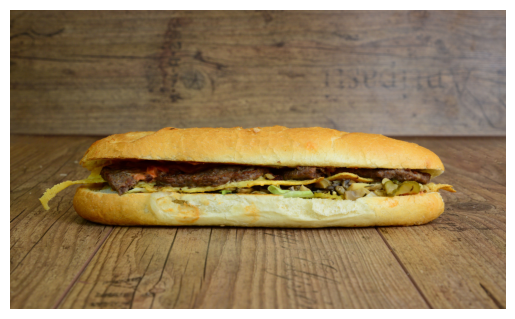

The predicted class for the image is: sandwich


In [109]:
image_path_2 = './images/test/sandwich/test_3.jpg'
predict_image(best_model, image_path_2)